# **Reporte del Modelo Final**
---

In [2]:
# Librerias
!pip install keras-tuner
import os
import requests
import logging
import keras_tuner
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.1 MB/s eta 0:00:00


In [3]:
# Funcion para crear el objeto de creación de logs
def create_logger():
  logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levenname)s - %(message)s')
  logger = logging.getLogger('Logger')
  logger.info('Logger creado')
  return logger

In [4]:
# Función de consumo a la base de datos de Firebase para cargar el DataSet
def download_firebase(url, logger):
  logger.info("Extrayendo el archivo desde Firebase")
  df = None
  try:
    df = pd.read_csv(url)
    logger.info("Archivo cargado")
  except requests.exceptions.RequestException as e:
    logger.info(f"Error al descargar el archivo CSV: {e}")
  except pd.errors.EmptyDataError:
    logger.info("El archivo CSV está vacío.")
  except Exception as e:
    logger.info(f"Ocurrió un error inesperado: {e}")
  return df

In [5]:
# Cargar DataSet
url = 'https://firebasestorage.googleapis.com/v0/b/personalwp-8822c.appspot.com/o/diabetes_prediction_dataset.csv?alt=media&token=4d70d154-c3d0-4fa0-a3aa-9b9972dd3b95'
logger = create_logger()
df = download_firebase(url, logger)

In [6]:
# Eliminación de valores atípicos y duplicados
seventy_fifth = df['bmi'].quantile(0.75)
twenty_fifth = df['bmi'].quantile(0.25)
iqr = seventy_fifth - twenty_fifth
upper = seventy_fifth + (10 * iqr)
outliers_bmi_upper = df[(df['bmi'] > upper)]
df = pd.merge(df, outliers_bmi_upper, indicator = True, how = 'outer').query('_merge == "left_only"').drop('_merge', axis = 1)
df = df.drop_duplicates(keep = "first")

In [7]:
# Variables Categóricas a Numéricas
df['gender'] = pd.factorize(df['gender'])[0]
df['smoking_history'] = pd.factorize(df['smoking_history'])[0]

## **Evaluación de Modelos**

### **Partición de Datos**

In [8]:
# Separación de la 'Data' (Características)
X = df.drop(columns = 'diabetes')
X.shape

(96143, 8)

In [9]:
# Separación del 'Target' (Variable objetivo)
y = df['diabetes']
y.shape

(96143,)

In [10]:
# Partición de los datos: 70% para entrenamiento, 30% para prueba y estratificación en las etiquetas (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [11]:
# Validación de la partición de los datos
print(f'Número de muestras en entrenamiento: {X_train.shape[0]}')
print(f'Número de muestras en prueba: {X_test.shape[0]}')
print(f'Número de características: {X_train.shape[1]}')

Número de muestras en entrenamiento: 67300
Número de muestras en prueba: 28843
Número de características: 8


In [12]:
# Distribución de la variable objetivo en los conjuntos de entrenamiento y prueba
print(f'Distribución de clases en entrenamiento: {np.bincount(y_train)}')
print(f'Distribución de clases en prueba: {np.bincount(y_test)}')

Distribución de clases en entrenamiento: [61363  5937]
Distribución de clases en prueba: [26298  2545]


### **Metricas para K-vecinos mas Cercanos**

In [13]:
# Entrenamiento del mejor modelo
model_KNC = KNeighborsClassifier(n_neighbors = 9).fit(X_train, y_train)

In [14]:
# Reporte de clasificación
KNC_prediction = model_KNC.predict(X_test)
KNC_report = classification_report(y_test, KNC_prediction, digits = 4)
print(KNC_report)

              precision    recall  f1-score   support

           0     0.9531    0.9963    0.9743     26298
           1     0.9284    0.4939    0.6448      2545

    accuracy                         0.9520     28843
   macro avg     0.9408    0.7451    0.8095     28843
weighted avg     0.9510    0.9520    0.9452     28843



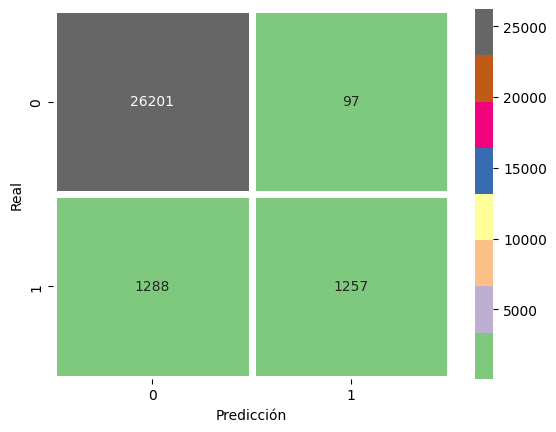

In [15]:
# Matriz de confusión
cm = confusion_matrix(y_test, KNC_prediction)
cm = pd.DataFrame(data = cm, columns = np.unique(y_test), index = np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot = True, fmt = ".0f", ax = ax, linewidths = 5, linecolor = 'white', cmap = 'Accent')
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
plt.savefig("confusion_matrix_knn.jpg")
fig.show()

### **Metricas para Arboles de Decisión**

In [16]:
# Entrenamiento del mejor modelo
model_DTC = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train)

In [17]:
# Reporte de clasificación
DTC_prediction = model_DTC.predict(X_test)
DTC_report = classification_report(y_test, DTC_prediction, digits = 4)
print(DTC_report)

              precision    recall  f1-score   support

           0     0.9691    1.0000    0.9843     26298
           1     1.0000    0.6703    0.8026      2545

    accuracy                         0.9709     28843
   macro avg     0.9845    0.8352    0.8935     28843
weighted avg     0.9718    0.9709    0.9683     28843



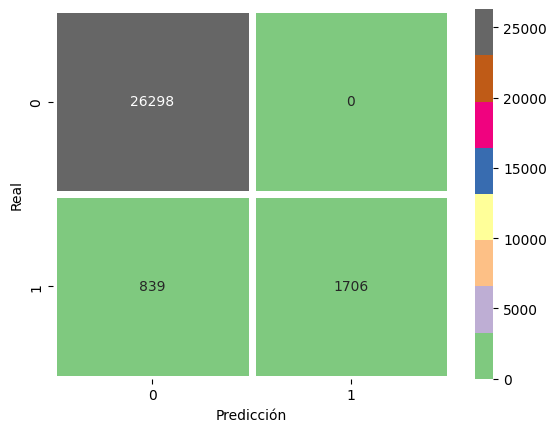

In [18]:
# Matriz de confusión
cm = confusion_matrix(y_test, DTC_prediction)
cm = pd.DataFrame(data = cm, columns = np.unique(y_test), index = np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot = True, fmt = ".0f", ax = ax, linewidths = 5, linecolor = 'white', cmap = 'Accent')
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
plt.savefig("confusion_matrix_dt.jpg")
fig.show()

### **Metricas para Bayesiano Ingenuo Multinomial**

In [19]:
# Entrenamiento del mejor modelo
model_MNB = MultinomialNB(alpha = 9933.355154619714).fit(X_train, y_train)

In [20]:
# Reporte de clasificación
MNB_prediction = model_MNB.predict(X_test)
MNB_report = classification_report(y_test, MNB_prediction, digits = 4)
print(MNB_report)

              precision    recall  f1-score   support

           0     0.9127    0.9927    0.9510     26298
           1     0.1975    0.0185    0.0338      2545

    accuracy                         0.9068     28843
   macro avg     0.5551    0.5056    0.4924     28843
weighted avg     0.8496    0.9068    0.8701     28843



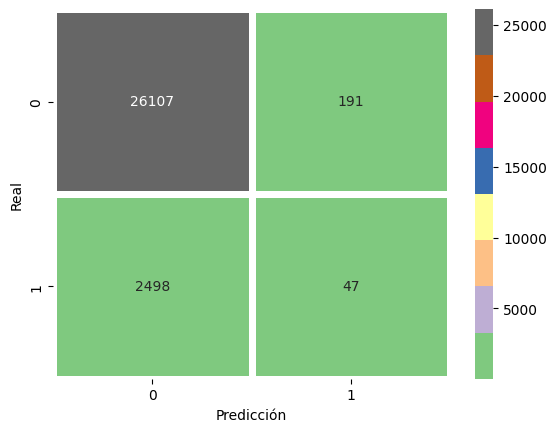

In [21]:
# Matriz de confusión
cm = confusion_matrix(y_test, MNB_prediction)
cm = pd.DataFrame(data = cm, columns = np.unique(y_test), index = np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot = True, fmt = ".0f", ax = ax, linewidths = 5, linecolor = 'white', cmap = 'Accent')
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
plt.savefig("confusion_matrix_mnb.jpg")
fig.show()

### **Metricas para Aumento de Gradiente Extremo**

In [22]:
# Entrenamiento del mejor modelo
model_XGBC = XGBClassifier(max_depth = 48, n_estimators = 130, learning_rate = 0.010291737939302062).fit(X_train, y_train)

In [23]:
# Reporte de clasificación
XGBC_prediction = model_XGBC.predict(X_test)
XGBC_report = classification_report(y_test, XGBC_prediction, digits = 4)
print(XGBC_report)

              precision    recall  f1-score   support

           0     0.9698    0.9995    0.9844     26298
           1     0.9920    0.6782    0.8056      2545

    accuracy                         0.9711     28843
   macro avg     0.9809    0.8388    0.8950     28843
weighted avg     0.9717    0.9711    0.9686     28843



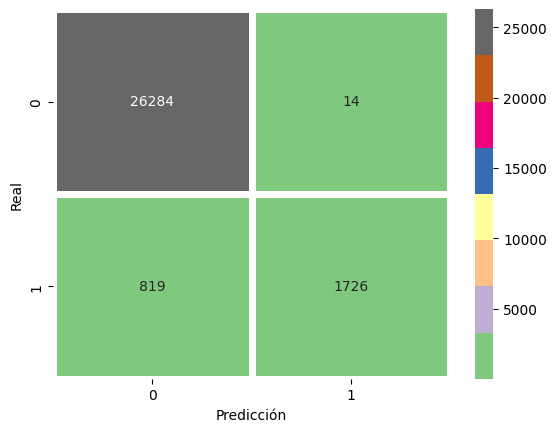

In [24]:
# Matriz de confusión
cm = confusion_matrix(y_test, XGBC_prediction)
cm = pd.DataFrame(data = cm, columns = np.unique(y_test), index = np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot = True, fmt = ".0f", ax = ax, linewidths = 5, linecolor = 'white', cmap = 'Accent')
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
plt.savefig("confusion_matrix_xgb.jpg")
fig.show()

### **Metricas para Redes Neuronales Multicapa**

In [25]:
# Función para la definición y compilación del modelo
def model_set_up(units_1, activation, dropout, units_2, learning_rate):
  input = tf.keras.layers.Input(shape = (8,))
  int_dense_1 = tf.keras.layers.Dense(units = units_1)(input)
  int_activ_1 = tf.keras.layers.Activation(activation = activation)(int_dense_1)
  if dropout:
    int_drop = tf.keras.layers.Dropout(0.2)(int_activ_1)
    int_dense_2 = tf.keras.layers.Dense(units = units_2)(int_drop)
  else:
    int_dense_2 = tf.keras.layers.Dense(units = units_2)(int_activ_1)
  int_activ_2 = tf.keras.layers.Activation(activation = activation)(int_dense_2)
  output = tf.keras.layers.Dense(units = 1, activation = "softmax")(int_activ_2)
  model = tf.keras.models.Model(inputs = [input], outputs = [output])
  model.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics=["accuracy"])
  return model

In [26]:
# Entrenamiento del mejor modelo
input = tf.keras.layers.Input(shape = (8,))
int_dense_1 = tf.keras.layers.Dense(units = 352)(input)
int_activ_1 = tf.keras.layers.Activation(activation = 'relu')(int_dense_1)
int_dense_2 = tf.keras.layers.Dense(units = 192)(int_activ_1)
int_activ_2 = tf.keras.layers.Activation(activation = 'relu')(int_dense_2)
output = tf.keras.layers.Dense(units = 1, activation = "softmax")(int_activ_2)
model_MNN = tf.keras.models.Model(inputs = [input], outputs = [output])
model_MNN.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = tf.keras.optimizers.Adam(learning_rate =  0.005977728042983696), metrics = ["accuracy"])
history_MNN = model_MNN.fit(X_train, y_train, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


2104/2104 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0882 - loss: 0.0000e+00
Epoch 2/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0858 - loss: 0.0000e+00
Epoch 3/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0907 - loss: 0.0000e+00
Epoch 4/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0893 - loss: 0.0000e+00
Epoch 5/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0905 - loss: 0.0000e+00
Epoch 6/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0881 - loss: 0.0000e+00
Epoch 7/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0887 - loss: 0.0000e+00
Epoch 8/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0882 - loss: 0.0000e+00
Epoch 9/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0871 - loss: 0.0000e+00
Epoch 10/10
2104/2104 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.0878 - loss: 0.0000e+00


In [27]:
# Reporte de clasificación
MNN_prediction = np.rint(model_MNN.predict(x = X_test))
MNN_report = classification_report(y_test, MNN_prediction, digits = 4)
print(MNN_report)

 44/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step    

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


885/902 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     26298
           1     0.0882    1.0000    0.1622      2545

    accuracy                         0.0882     28843
   macro avg     0.0441    0.5000    0.0811     28843
weighted avg     0.0078    0.0882    0.0143     28843



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


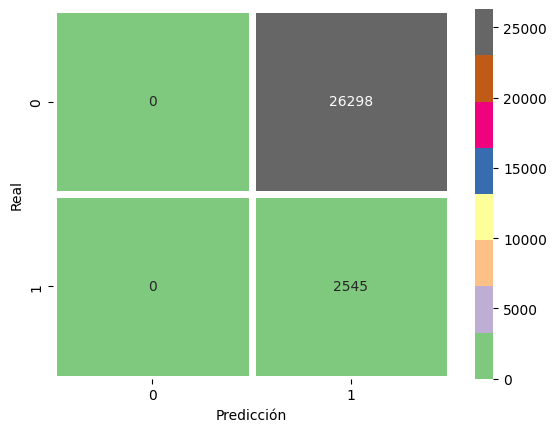

In [28]:
# Matriz de confusión
cm = confusion_matrix(y_test, MNN_prediction)
cm = pd.DataFrame(data = cm, columns = np.unique(y_test), index = np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot = True, fmt = ".0f", ax = ax, linewidths = 5, linecolor = 'white', cmap = 'Accent')
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
plt.savefig("confusion_matrix_mnn.jpg")
fig.show()

### **Comparación de Resultados**
---

In [29]:
# Accuracy de los modelos evaluados
KNC_acc = accuracy_score(y_test, KNC_prediction) * 100
DTC_acc = accuracy_score(y_test, DTC_prediction) * 100
MNB_acc = accuracy_score(y_test, MNB_prediction) * 100
XGBC_acc = accuracy_score(y_test, XGBC_prediction) * 100
MNN_acc = accuracy_score(y_test, MNN_prediction) * 100
columns = ["Modelo", "Accuracy"]
data = [["KNN", KNC_acc], ["DT", DTC_acc], ["MNB", MNB_acc], ["XGB", XGBC_acc], ["MNN", MNN_acc]]
accuracy = pd.DataFrame(data, columns = columns)
accuracy

,Modelo,Accuracy
0,KNN,95.198142
1,DT,97.091149
2,MNB,90.677114
3,XGB,97.111951
4,MNN,8.823631


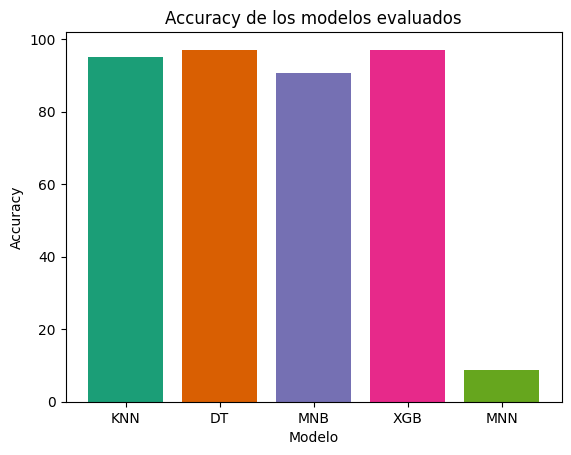

In [30]:
# Histograma de Accuracy
plt.title('Accuracy de los modelos evaluados')
plt.xlabel("Modelo")
plt.ylabel("Accuracy")
plt.bar(accuracy['Modelo'], accuracy['Accuracy'], color = sns.palettes.mpl_palette('Dark2'))
plt.savefig("models_accuracy.jpg")
plt.show()

In [31]:
# Precisión de los modelos evaluados
KNC_pre_0 = precision_score(y_test, KNC_prediction, pos_label = 0) * 100
DTC_pre_0 = precision_score(y_test, DTC_prediction, pos_label = 0) * 100
MNB_pre_0 = precision_score(y_test, MNB_prediction, pos_label = 0) * 100
XGBC_pre_0 = precision_score(y_test, XGBC_prediction, pos_label = 0) * 100
MNN_pre_0 = precision_score(y_test, MNN_prediction, pos_label = 0) * 100
KNC_pre_1 = precision_score(y_test, KNC_prediction, pos_label = 1) * 100
DTC_pre_1 = precision_score(y_test, DTC_prediction, pos_label = 1) * 100
MNB_pre_1 = precision_score(y_test, MNB_prediction, pos_label = 1) * 100
XGBC_pre_1 = precision_score(y_test, XGBC_prediction, pos_label = 1) * 100
MNN_pre_1 = precision_score(y_test, MNN_prediction, pos_label = 1) * 100
columns = ["Modelo", "Precision_0", "Precision_1"]
data = [["KNN", KNC_pre_0, KNC_pre_1], ["DT", DTC_pre_0, DTC_pre_1], ["MNB", MNB_pre_0, MNB_pre_1], ["XGB", XGBC_pre_0, XGBC_pre_1], ["MNN", MNN_pre_0, MNN_pre_1]]
precision = pd.DataFrame(data, columns = columns)
precision

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Modelo,Precision_0,Precision_1
0,KNN,95.314489,92.836041
1,DT,96.908280,100.000000
2,MNB,91.267261,19.747899
3,XGB,96.978194,99.195402
4,MNN,0.000000,8.823631


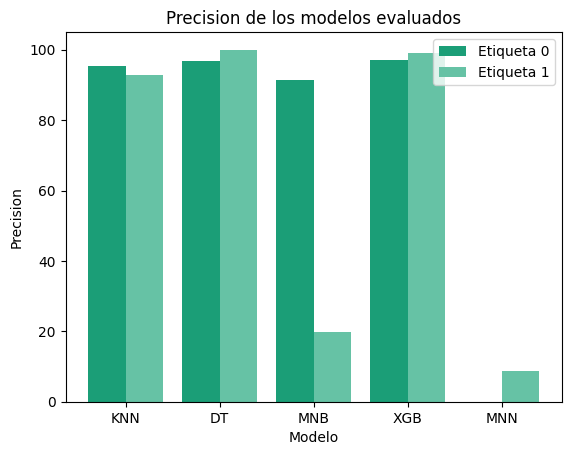

In [32]:
# Histograma de Precisión
plt.title('Precision de los modelos evaluados')
plt.xlabel("Modelo")
plt.ylabel("Precision")
x = np.arange(len(precision['Modelo']))
plt.bar(x, precision['Precision_0'], width = 0.4, label = 'Etiqueta 0', color = "#1B9E77")
plt.bar(x + 0.4, precision['Precision_1'], width = 0.4, label = 'Etiqueta 1', color = "#66C2A5")
plt.xticks(x + 0.2, ["KNN", "DT", "MNB", "XGB", "MNN"])
plt.legend()
plt.savefig("models_precision.jpg")
plt.show()

In [33]:
# Recall de los modelos evaluados
KNC_rec_0 = recall_score(y_test, KNC_prediction, pos_label = 0) * 100
DTC_rec_0 = recall_score(y_test, DTC_prediction, pos_label = 0) * 100
MNB_rec_0 = recall_score(y_test, MNB_prediction, pos_label = 0) * 100
XGBC_rec_0 = recall_score(y_test, XGBC_prediction, pos_label = 0) * 100
MNN_rec_0 = recall_score(y_test, MNN_prediction, pos_label = 0) * 100
KNC_rec_1 = recall_score(y_test, KNC_prediction, pos_label = 1) * 100
DTC_rec_1 = recall_score(y_test, DTC_prediction, pos_label = 1) * 100
MNB_rec_1 = recall_score(y_test, MNB_prediction, pos_label = 1) * 100
XGBC_rec_1 = recall_score(y_test, XGBC_prediction, pos_label = 1) * 100
MNN_rec_1 = recall_score(y_test, MNN_prediction, pos_label = 1) * 100
columns = ["Modelo", "Recall_0", "Recall_1"]
data = [["KNN", KNC_rec_0, KNC_rec_1], ["DT", DTC_rec_0, DTC_rec_1], ["MNB", MNB_rec_0, MNB_rec_1], ["XGB", XGBC_rec_0, XGBC_rec_1], ["MNN", MNN_rec_0, MNN_rec_1]]
recall = pd.DataFrame(data, columns = columns)
recall

,Modelo,Recall_0,Recall_1
0,KNN,99.631151,49.390963
1,DT,100.000000,67.033399
2,MNB,99.273709,1.846758
3,XGB,99.946764,67.819253
4,MNN,0.000000,100.000000


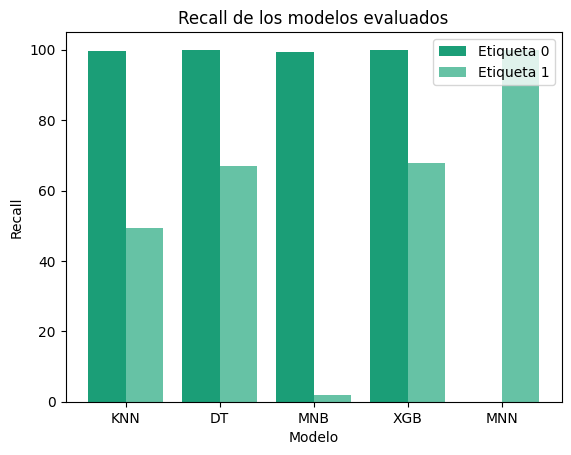

In [34]:
# Histograma de Recall
plt.title('Recall de los modelos evaluados')
plt.xlabel("Modelo")
plt.ylabel("Recall")
x = np.arange(len(recall['Modelo']))
plt.bar(x, recall['Recall_0'], width = 0.4, label = 'Etiqueta 0', color = "#1B9E77")
plt.bar(x + 0.4, recall['Recall_1'], width = 0.4, label = 'Etiqueta 1', color = "#66C2A5")
plt.xticks(x + 0.2, ["KNN", "DT", "MNB", "XGB", "MNN"])
plt.legend()
plt.savefig("models_recall.jpg")
plt.show()

In [35]:
# F1-score de los modelos evaluados
KNC_f1s_0 = f1_score(y_test, KNC_prediction, pos_label = 0) * 100
DTC_f1s_0 = f1_score(y_test, DTC_prediction, pos_label = 0) * 100
MNB_f1s_0 = f1_score(y_test, MNB_prediction, pos_label = 0) * 100
XGBC_f1s_0 = f1_score(y_test, XGBC_prediction, pos_label = 0) * 100
MNN_f1s_0 = f1_score(y_test, MNN_prediction, pos_label = 0) * 100
KNC_f1s_1 = f1_score(y_test, KNC_prediction, pos_label = 1) * 100
DTC_f1s_1 = f1_score(y_test, DTC_prediction, pos_label = 1) * 100
MNB_f1s_1 = f1_score(y_test, MNB_prediction, pos_label = 1) * 100
XGBC_f1s_1 = f1_score(y_test, XGBC_prediction, pos_label = 1) * 100
MNN_f1s_1 = f1_score(y_test, MNN_prediction, pos_label = 1) * 100
columns = ["Modelo", "F1-score_0", "F1-score_1"]
data = [["KNN", KNC_f1s_0, KNC_f1s_1], ["DT", DTC_f1s_0, DTC_f1s_1], ["MNB", MNB_f1s_0, MNB_f1s_1], ["XGB", XGBC_f1s_0, XGBC_f1s_1], ["MNN", MNN_f1s_0, MNN_f1s_1]]
f1score = pd.DataFrame(data, columns = columns)
f1score

,Modelo,F1-score_0,F1-score_1
0,KNN,97.425028,64.478071
1,DT,98.429868,80.263467
2,MNB,95.102271,3.377650
3,XGB,98.440104,80.560093
4,MNN,0.000000,16.216388


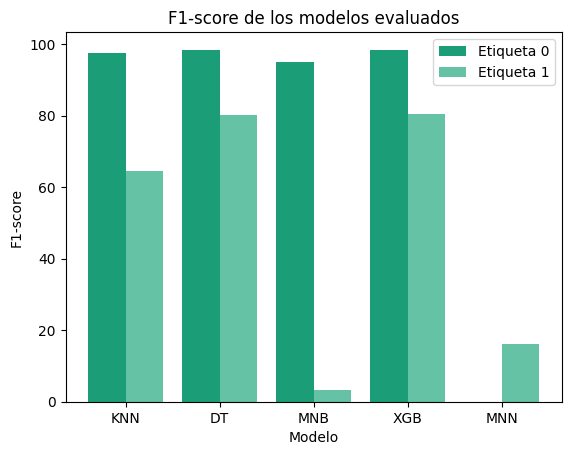

In [36]:
# Histograma de F1-score
plt.title('F1-score de los modelos evaluados')
plt.xlabel("Modelo")
plt.ylabel("F1-score")
x = np.arange(len(f1score['Modelo']))
plt.bar(x, f1score['F1-score_0'], width = 0.4, label = 'Etiqueta 0', color = "#1B9E77")
plt.bar(x + 0.4, f1score['F1-score_1'], width = 0.4, label = 'Etiqueta 1', color = "#66C2A5")
plt.xticks(x + 0.2, ["KNN", "DT", "MNB", "XGB", "MNN"])
plt.legend()
plt.savefig("models_f1score.jpg")
plt.show()

### **Mejor Modelo**
---

In [37]:
# Metricas de desempeño mejor modelo
columns = ["Métricas", "Porcentaje_0", "Porcentaje_1"]
data = [["Precision", XGBC_pre_0, XGBC_pre_1], ["Recall", XGBC_rec_0, XGBC_rec_1], ["F1-score", XGBC_f1s_0, XGBC_f1s_1]]
metrics = pd.DataFrame(data, columns = columns)
metrics

,Métricas,Porcentaje_0,Porcentaje_1
0,Precision,96.978194,99.195402
1,Recall,99.946764,67.819253
2,F1-score,98.440104,80.560093


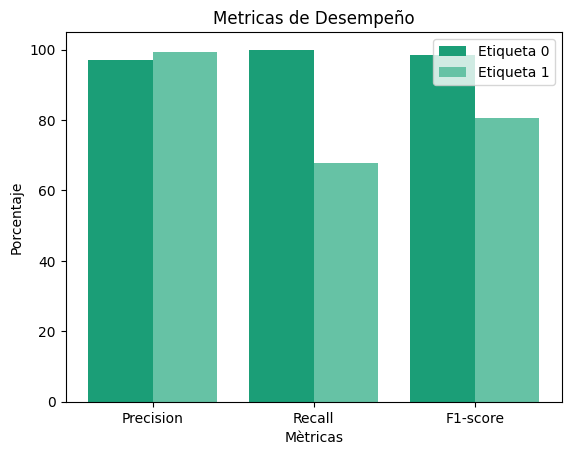

In [38]:
# Histograma de Accuracy
plt.title('Metricas de Desempeño')
plt.xlabel("Mètricas")
plt.ylabel("Porcentaje")
x = np.arange(len(metrics['Métricas']))
plt.bar(x, metrics['Porcentaje_0'], width = 0.4, label = 'Etiqueta 0', color = "#1B9E77")
plt.bar(x + 0.4, metrics['Porcentaje_1'], width = 0.4, label = 'Etiqueta 1', color = "#66C2A5")
plt.xticks(x + 0.2, ["Precision", "Recall", "F1-score"])
plt.legend()
plt.savefig("xgb_model_metrics.jpg")
plt.show()

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*